Predicting players rating

In this project you are going to predict the overall rating of soccer player based on their attributes
such as 'crossing', 'finishing etc.
The dataset you are going to use is from European Soccer Database
(https://www.kaggle.com/hugomathien/soccer) has more than 25,000 matches and more than
10,000 players for European professional soccer seasons from 2008 to 2016.
Download the data in the same folder and run the following commmand to get it in the environment

About the Dataset The ultimate Soccer database for data analysis and machine learning The dataset comes in the form of an SQL database and contains statistics of about 25,000 footballmatches, from the top football league of 11 European Countries. It covers seasons from 2008 to 2016 and contains match statistics (i.e: scores, corners, fouls etc...) as well as the team formations,with player names and a pair of coordinates to indicate their position on the pitch.

+25,000 matches +10,000 players 11 European Countries with their lead championship Seasons 2008 to 2016 Players and Teams' attributes* sourced from EA Sports' FIFA video game series, including the weekly updates Team line up with squad formation (X, Y coordinates) Betting odds from up to 10 providers Detailed match events (goal types, possession, corner, cross, fouls, cards etc...) for +10,000 matches


The dataset also has a set of about 35 statistics for each player, derived from EA Sports' FIFA video games. It is not just the stats that come with a new version of the game but also the weekly updates. So for instance if a player has performed poorly over a period of time and his stats get impacted in FIFA, you would normally see the same in the dataset.

In [1]:
import sqlite3
import numpy as np
import pandas as pd
%matplotlib notebook
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from xgboost import plot_importance

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit, RandomizedSearchCV
from sklearn.pipeline import make_pipeline

import pickle

In [2]:
# Create your connection.
cnx = sqlite3.connect('database.sqlite')
#df = pd.read_sql_query("SELECT * FROM Player_Attributes", cnx)

In [3]:
dd = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table'", cnx)

In [4]:
print(dd)

                name
0    sqlite_sequence
1  Player_Attributes
2             Player
3              Match
4             League
5            Country
6               Team
7    Team_Attributes


# Data Preparation

In [5]:
df = pd.read_sql_query("SELECT * FROM Player_Attributes", cnx)

In [6]:
df.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [7]:
df.describe()

,id,player_fifa_api_id,player_api_id,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
count,183978.00000,183978.000000,183978.000000,183142.000000,183142.000000,183142.000000,183142.000000,183142.000000,183142.000000,181265.000000,...,181265.000000,183142.000000,183142.000000,183142.000000,181265.000000,183142.000000,183142.000000,183142.000000,183142.000000,183142.000000
mean,91989.50000,165671.524291,135900.617324,68.600015,73.460353,55.086883,49.921078,57.266023,62.429672,49.468436,...,57.873550,55.003986,46.772242,50.351257,48.001462,14.704393,16.063612,20.998362,16.132154,16.441439
std,53110.01825,53851.094769,136927.840510,7.041139,6.592271,17.242135,19.038705,16.488905,14.194068,18.256618,...,15.144086,15.546519,21.227667,21.483706,21.598778,16.865467,15.867382,21.452980,16.099175,17.198155
min,1.00000,2.000000,2625.000000,33.000000,39.000000,1.000000,1.000000,1.000000,3.000000,1.000000,...,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,45995.25000,155798.000000,34763.000000,64.000000,69.000000,45.000000,34.000000,49.000000,57.000000,35.000000,...,49.000000,45.000000,25.000000,29.000000,25.000000,7.000000,8.000000,8.000000,8.000000,8.000000
50%,91989.50000,183488.000000,77741.000000,69.000000,74.000000,59.000000,53.000000,60.000000,65.000000,52.000000,...,60.000000,57.000000,50.000000,56.000000,53.000000,10.000000,11.000000,12.000000,11.000000,11.000000
75%,137983.75000,199848.000000,191080.000000,73.000000,78.000000,68.000000,65.000000,68.000000,72.000000,64.000000,...,69.000000,67.000000,66.000000,69.000000,67.000000,13.000000,15.000000,15.000000,15.000000,15.000000
max,183978.00000,234141.000000,750584.000000,94.000000,97.000000,95.000000,97.000000,98.000000,97.000000,93.000000,...,97.000000,96.000000,96.000000,95.000000,95.000000,94.000000,93.000000,97.000000,96.000000,96.000000


In [8]:
target = df.pop('overall_rating')

In [9]:
df.shape

(183978, 41)

In [10]:
target.head()

0    67.0
1    67.0
2    62.0
3    61.0
4    61.0
Name: overall_rating, dtype: float64

# Handling missing vale

In [11]:
target.isnull().values.sum()

836

there are 836 missing value present in target function.

In [12]:
target.describe()

count    183142.000000
mean         68.600015
std           7.041139
min          33.000000
25%          64.000000
50%          69.000000
75%          73.000000
max          94.000000
Name: overall_rating, dtype: float64

<IPython.core.display.Javascript object>


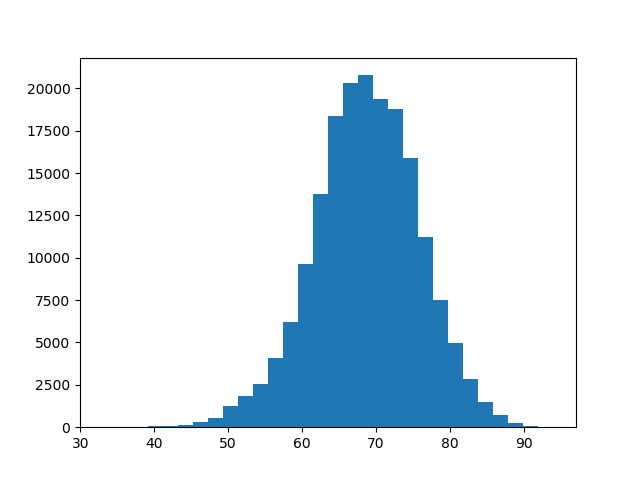

C:\Users\Dr Arun Abraham\Anaconda3\lib\site-packages\numpy\lib\function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Dr Arun Abraham\Anaconda3\lib\site-packages\numpy\lib\function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([7.0000e+00, 6.0000e+00, 2.0000e+01, 6.5000e+01, 9.4000e+01,
        1.4200e+02, 2.9400e+02, 5.2600e+02, 1.2510e+03, 1.8450e+03,
        2.5780e+03, 4.0870e+03, 6.1890e+03, 9.6500e+03, 1.3745e+04,
        1.8366e+04, 2.0310e+04, 2.0773e+04, 1.9382e+04, 1.8784e+04,
        1.5915e+04, 1.1254e+04, 7.5250e+03, 4.9470e+03, 2.8290e+03,
        1.4590e+03, 7.4800e+02, 2.2800e+02, 8.4000e+01, 3.9000e+01]),
 array([33.        , 35.03333333, 37.06666667, 39.1       , 41.13333333,
        43.16666667, 45.2       , 47.23333333, 49.26666667, 51.3       ,
        53.33333333, 55.36666667, 57.4       , 59.43333333, 61.46666667,
        63.5       , 65.53333333, 67.56666667, 69.6       , 71.63333333,
        73.66666667, 75.7       , 77.73333333, 79.76666667, 81.8       ,
        83.83333333, 85.86666667, 87.9       , 89.93333333, 91.96666667,
        94.        ]),
 <a list of 30 Patch objects>)

In [13]:
plt.hist(target, 30, range=(33, 94))

almost normal distribution so we can impute mean value for missing value in target.

In [14]:
y = target.fillna(target.mean())

In [15]:
y.isnull().values.any()

False

## Data Exploration :

In [16]:
df.columns

Index(['id', 'player_fifa_api_id', 'player_api_id', 'date', 'potential',
       'preferred_foot', 'attacking_work_rate', 'defensive_work_rate',
       'crossing', 'finishing', 'heading_accuracy', 'short_passing', 'volleys',
       'dribbling', 'curve', 'free_kick_accuracy', 'long_passing',
       'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions',
       'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots',
       'aggression', 'interceptions', 'positioning', 'vision', 'penalties',
       'marking', 'standing_tackle', 'sliding_tackle', 'gk_diving',
       'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes'],
      dtype='object')

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183978 entries, 0 to 183977
Data columns (total 41 columns):
id                     183978 non-null int64
player_fifa_api_id     183978 non-null int64
player_api_id          183978 non-null int64
date                   183978 non-null object
potential              183142 non-null float64
preferred_foot         183142 non-null object
attacking_work_rate    180748 non-null object
defensive_work_rate    183142 non-null object
crossing               183142 non-null float64
finishing              183142 non-null float64
heading_accuracy       183142 non-null float64
short_passing          183142 non-null float64
volleys                181265 non-null float64
dribbling              183142 non-null float64
curve                  181265 non-null float64
free_kick_accuracy     183142 non-null float64
long_passing           183142 non-null float64
ball_control           183142 non-null float64
acceleration           183142 non-null float64
sprint

In [19]:
for col in df.columns:
    unique_cat = len(df[col].unique())
    print("{col}--> {unique_cat}".format(col=col, unique_cat=unique_cat,))

id--> 183978
player_fifa_api_id--> 11062
player_api_id--> 11060
date--> 197
potential--> 57
preferred_foot--> 3
attacking_work_rate--> 9
defensive_work_rate--> 20
crossing--> 96
finishing--> 98
heading_accuracy--> 97
short_passing--> 96
volleys--> 94
dribbling--> 98
curve--> 93
free_kick_accuracy--> 98
long_passing--> 96
ball_control--> 94
acceleration--> 87
sprint_speed--> 86
agility--> 82
reactions--> 79
balance--> 82
shot_power--> 97
jumping--> 80
stamina--> 85
strength--> 83
long_shots--> 97
aggression--> 92
interceptions--> 97
positioning--> 96
vision--> 98
penalties--> 95
marking--> 96
standing_tackle--> 96
sliding_tackle--> 95
gk_diving--> 94
gk_handling--> 91
gk_kicking--> 98
gk_positioning--> 95
gk_reflexes--> 93


we can see only four features have the type 'object'. here the feature named 'date' has no significance in this problem so can ignore it and perform one hot encoding on the rest of 3 features.

In [21]:
## here the feature named 'date' has no significance in this problem so can ignore it and perform one hot encoding on the rest of 3 features.
dummy_df = pd.get_dummies(df, columns=['preferred_foot', 'attacking_work_rate', 'defensive_work_rate'])
dummy_df.head()

,id,player_fifa_api_id,player_api_id,date,potential,crossing,finishing,heading_accuracy,short_passing,volleys,...,defensive_work_rate_9,defensive_work_rate__0,defensive_work_rate_ean,defensive_work_rate_es,defensive_work_rate_high,defensive_work_rate_low,defensive_work_rate_medium,defensive_work_rate_o,defensive_work_rate_ormal,defensive_work_rate_tocky
0,1,218353,505942,2016-02-18 00:00:00,71.0,49.0,44.0,71.0,61.0,44.0,...,0,0,0,0,0,0,1,0,0,0
1,2,218353,505942,2015-11-19 00:00:00,71.0,49.0,44.0,71.0,61.0,44.0,...,0,0,0,0,0,0,1,0,0,0
2,3,218353,505942,2015-09-21 00:00:00,66.0,49.0,44.0,71.0,61.0,44.0,...,0,0,0,0,0,0,1,0,0,0
3,4,218353,505942,2015-03-20 00:00:00,65.0,48.0,43.0,70.0,60.0,43.0,...,0,0,0,0,0,0,1,0,0,0
4,5,218353,505942,2007-02-22 00:00:00,65.0,48.0,43.0,70.0,60.0,43.0,...,0,0,0,0,0,0,1,0,0,0


In [22]:
X = dummy_df.drop(['id', 'date'], axis=1)

***
## Feature selection :

* As tree model doesn't gets affected by missing values present in data set. but feature selection by `SelectFromModel` can not be done on datasets that carries null value. Therefore, we should also perform imputation on dataset. 

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [24]:
#imputing null value of each column with the mean of that column
imput = Imputer()
X_train = imput.fit_transform(X_train)
X_test = imput.fit_transform(X_test)

In [25]:
#finding feature_importance for feature selection. from it we'll be able to decide threshold value
model = XGBRegressor()
model.fit(X_train, y_train)
print(model.feature_importances_)

[0.01714286 0.02       0.10714286 0.02       0.04714286 0.03571429
 0.03285714 0.         0.04       0.         0.         0.00714286
 0.04714286 0.01       0.01571429 0.00142857 0.18571429 0.
 0.01428571 0.00571429 0.00857143 0.03142857 0.00571429 0.00714286
 0.01857143 0.01857143 0.00571429 0.         0.04285714 0.04571429
 0.01       0.04571429 0.02571429 0.02428572 0.06       0.04285714
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]


In [26]:
selection = SelectFromModel(model, threshold=0.01, prefit=True)

select_X_train = selection.transform(X_train)
select_X_test = selection.transform(X_test)

In [27]:
select_X_train.shape

(137983, 24)

## Training different models :

### 1. Linear Regression :

In [28]:
pipe = make_pipeline(StandardScaler(),             #preprocessing(standard scalling)
                     LinearRegression())           #estimator(linear regression)

cv = ShuffleSplit(random_state=0)   #defining type of cross_validation(shuffle spliting)

param_grid = {'linearregression__n_jobs': [-1]}     #parameters for model tunning

grid = GridSearchCV(pipe, param_grid=param_grid, cv=cv)

In [29]:
grid.fit(select_X_train, y_train)          #training 

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size='default',
       train_size=None),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'linearregression__n_jobs': [-1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [30]:
grid.best_params_

{'linearregression__n_jobs': -1}

In [31]:
lin_reg = pickle.dumps(grid)

### 2. Decision Tree :

In [32]:
pipe = make_pipeline(StandardScaler(),                  #preprocessing
                     DecisionTreeRegressor(criterion='mse', random_state=0))          #estimator

cv = ShuffleSplit(n_splits=10, random_state=42)        #cross validation

param_grid = {'decisiontreeregressor__max_depth': [3, 5, 7, 9, 13]}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=cv)

In [33]:
grid.fit(select_X_train, y_train)          #training 

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=42, test_size='default',
       train_size=None),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('decisiontreeregressor', DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best'))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'decisiontreeregressor__max_depth': [3, 5, 7, 9, 13]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [34]:
grid.best_params_

{'decisiontreeregressor__max_depth': 13}

In [35]:
Dectree_reg = pickle.dumps(grid)

### 3. Ranom Forest :

In [36]:
pipe = make_pipeline(StandardScaler(),
                     RandomForestRegressor(n_estimators=500, random_state=123))

cv = ShuffleSplit(test_size=0.2, random_state=0)

param_grid = {'randomforestregressor__max_features':['sqrt', 'log2', 10],
              'randomforestregressor__max_depth':[9, 11, 13]}                 

grid = GridSearchCV(pipe, param_grid=param_grid, cv=cv)

In [37]:
grid.fit(select_X_train, y_train)          #training 

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.2, train_size=None),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('randomforestregressor', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decr...imators=500, n_jobs=1,
           oob_score=False, random_state=123, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'randomforestregressor__max_features': ['sqrt', 'log2', 10], 'randomforestregressor__max_depth': [9, 11, 13]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [38]:
grid.best_params_

{'randomforestregressor__max_depth': 13,
 'randomforestregressor__max_features': 10}

In [39]:
Randfor_reg = pickle.dumps(grid)

### 4. Xgboost regressor :

In [42]:
pipe = make_pipeline(StandardScaler(),
                     XGBRegressor(n_estimators= 500, random_state=42))

cv = ShuffleSplit(n_splits=10, random_state=0)

param_grid = {'xgbregressor__max_depth': [5, 7],
              'xgbregressor__learning_rate': [0.1, 0.3]}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=cv, n_jobs= -1)

In [43]:
grid.fit(select_X_train, y_train)

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size='default',
       train_size=None),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('xgbregressor', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, ...       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'xgbregressor__max_depth': [5, 7], 'xgbregressor__learning_rate': [0.1, 0.3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [44]:
grid.best_params_

{'xgbregressor__learning_rate': 0.3, 'xgbregressor__max_depth': 7}

In [45]:
xgbreg = pickle.dumps(grid)

## <u>Comparision between different models</u> :

In [48]:
lin_reg = pickle.loads(lin_reg)
Dectree_reg = pickle.loads(Dectree_reg)
Randfor_reg = pickle.loads(Randfor_reg)
xgbreg = pickle.loads(xgbreg)

In [49]:
print("""Linear Regressor accuracy is {lin}
DecisionTree Regressor accuracy is {Dec}
RandomForest regressor accuracy is {ran}
XGBoost regressor accuracy is {xgb}""".format(lin=lin_reg.score(select_X_test, y_test),
                                                       Dec=Dectree_reg.score(select_X_test, y_test),
                                                       ran=Randfor_reg.score(select_X_test, y_test),
                                                       xgb=xgbreg.score(select_X_test, y_test)))

Linear Regressor accuracy is 0.8547439877398585
DecisionTree Regressor accuracy is 0.9300656646020649
RandomForest regressor accuracy is 0.9642395895691055
XGBoost regressor accuracy is 0.9823349639170261


By accuracy comparision performed above we can say hear that XGBoost regressor gives better result than any other model. and it can predict the target function with approx 98% accuracy.